In [1]:
from copy import deepcopy
!pip install "gymnasium[mujoco]"
!pip install mpi4py

In [2]:
import os
import subprocess

In [3]:
env_file = 'model_downloader.py'
env_url = "https://raw.githubusercontent.com/alibaniasad1999/master-thesis/main/Code/Python/utils/model_downloader.py"

if not os.path.isfile(env_file):
    print(f"Downloading {env_file} ...")
    subprocess.run(
        ['wget', '-q', '-O', env_file, env_url],
        stdout=subprocess.DEVNULL,
        stderr=subprocess.DEVNULL
    )
    print(f"{env_file} downloaded.")
else:
    print(f"{env_file} already exists.")

from model_downloader import download_everything

trajectory = download_everything('zs_sac, TBP, sac_models')

model_downloader.py already exists.
trajectory.csv already exists.
Trajectory head:
   0.87018  -0.059444  0  -0.010472  -0.17514  0.1
0  0.87018  -0.059540  0  -0.010536  -0.17494    0
1  0.87017  -0.059636  0  -0.010600  -0.17474    0
2  0.87017  -0.059732  0  -0.010664  -0.17454    0
3  0.87016  -0.059828  0  -0.010728  -0.17434    0
4  0.87015  -0.059924  0  -0.010793  -0.17414    0
Data shape: (9999, 6)
TBP.py already exists.
Directory 'model' already exists and is not empty.
model/actor_cpu.pth already exists.
model/q1_cpu.pth already exists.
model/q2_cpu.pth already exists.


In [4]:
import torch
import Zero_Sum_SAC
from Zero_Sum_SAC import ZS_SAC
from TBP import ThreeBodyEnv
from utils.run_utils import setup_logger_kwargs
from Zero_Sum_SAC import colorize

Directory 'utils' already exists.
trajectory.csv already exists.


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print(colorize(f"Device is {device}! 🥰😎", 'green', bold=True))
# Define variables directly
env = ThreeBodyEnv(trajectory)
hid = 64
l = 2
gamma = 0.99
seed = 0
epochs = 50
exp_name = 'sac'
steps_per_epoch_=30000
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

ac_kwargs = dict(hidden_sizes=[hid]*l)
states_array = []
# logger_kwargs = setup_logger_kwargs(exp_name, seed)
reward_array=[]



sac_rl = ZS_SAC(lambda : ThreeBodyEnv(trajectory, error_range=0.01, final_range=0.001), epochs=100, device_class=device, ac_kwargs_class=ac_kwargs, steps_per_epoch=steps_per_epoch_, batch_size=1024, start_steps=5000, update_after=1000, update_every=2000)

Logging data to /tmp/experiments/1751829415/progress.txt
Saving config:

{
    "ac_kwargs_class":	{
        "hidden_sizes":	[
            64,
            64
        ]
    },
    "actor_critic":	"MLPActorCritic",
    "alpha":	0.2,
    "batch_size":	1024,
    "device_class":	"cpu",
    "env_fn":	"<function <lambda> at 0x117133d80>",
    "epochs":	100,
    "gamma":	0.99,
    "logger_kwargs":	null,
    "lr":	0.001,
    "max_ep_len":	30000,
    "num_test_episodes":	10,
    "num_updates":	10,
    "polyak":	0.995,
    "replay_size":	1000000,
    "save_freq":	1,
    "seed":	0,
    "self":	{
        "<Zero_Sum_SAC.ZS_SAC object at 0x14f1cf310>":	{
            "ac_kwargs":	{
                "hidden_sizes":	[
                    64,
                    64
                ]
            },
            "actor_critic":	"MLPActorCritic",
            "alpha":	0.2,
            "batch_size":	1024,
            "device":	"cpu",
            "env_fn":	"<function <lambda> at 0x117133d80>",
            "epochs

In [6]:
sac_rl.load()
sac_rl.load_1()

Model loaded successfully and device is cpu! 🥰😎
Model 1 loaded successfully and device is cpu! 🥰😎


done 🥺
second player was in the game
Data saved to results folder 😜


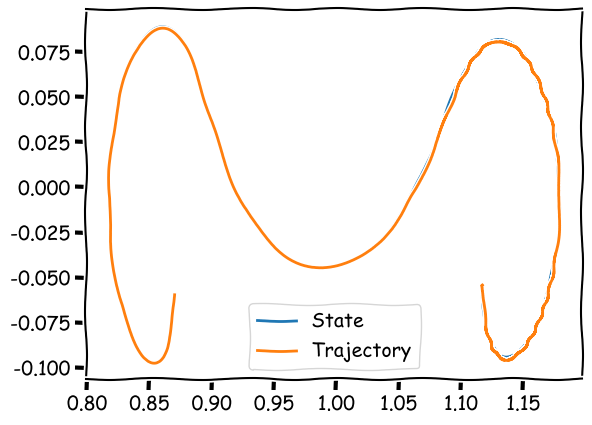

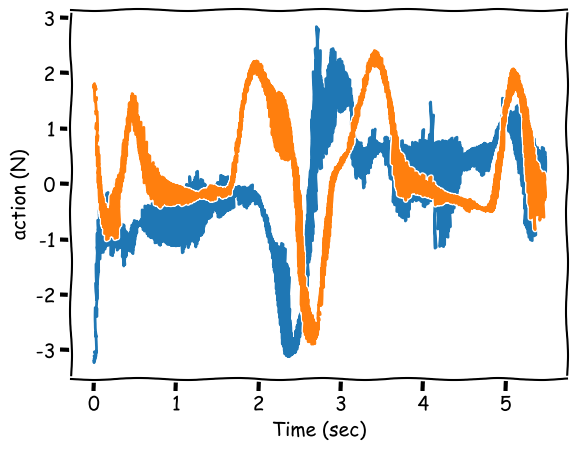

In [7]:
sac_rl.test(fun_mode=True, deterministic=True, save_data=True)

In [37]:
import torch
from copy import deepcopy

# Create a dedicated inference-only class that completely encapsulates the forward path
class DeterministicPolicy(torch.nn.Module):
    def __init__(self, policy):
        super().__init__()
        self.net = deepcopy(policy.net)
        self.mu_layer = deepcopy(policy.mu_layer)
        self.act_limit = policy.act_limit

        # Explicitly turn off gradients for all parameters
        for param in self.parameters():
            param.requires_grad_(False)

    def forward(self, obs):
        # Deterministic inference path only
        net_out = self.net(obs)
        mu = self.mu_layer(net_out)
        action = torch.tanh(mu) * self.act_limit
        return action

# Create inference-only model and set to eval mode
model_copy = deepcopy(sac_rl.ac.pi)
inference_model = DeterministicPolicy(model_copy).to(device)
inference_model.eval()

# Prepare sample input without requiring gradients
sample_input = torch.zeros(1, sac_rl.env.observation_space.shape[0], device=device)

# Trace the model with the sample input
with torch.no_grad():
    traced_model = torch.jit.trace(inference_model, sample_input)

# Save the traced model
if os.path.isdir('Cpp_models'):
    traced_model.save('Cpp_models/zs_sac_traced_deterministic.pt')
else:
    os.makedirs('Cpp_models')
    traced_model.save('Cpp_models/zs_sac_traced_deterministic.pt')
traced_model.save('../../../../C/model/zs_sac_traced_deterministic.pt')
print('Deterministic model saved for C++ inference.')

Deterministic model saved for C++ inference.
